### In this notebook, I try to add stellar mass and redshift into $\vec{\theta}$, plus noise into the data and forward models

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator, Photulator, StandardScaler

In [4]:
## Load the NN emulator `speculator`
with open('./speculator_best_recon_model.pkl', 'rb') as f:
    speculator = pickle.load(f)
speculator.network.eval();

In [140]:
noise = 'nsa'
noise_model_dir = './noise_model/nsa_noise_model_mag.npy'

In [185]:
y_data = np.random.multivariate_normal(mean=[6, 0], cov=[[0.5, 0.3], [0.3, 0.1]], size=5000)
#y_data1 = np.random.multivariate_normal(mean=[6, -1], cov=[[0.7, 0.], [0., 0.2]], size=2500)
#y_data2 = np.random.multivariate_normal(mean=[5, 1.5], cov=[[0.7, 0.], [0., 0.3]], size=2500)
#y_data2 = np.random.multivariate_normal(mean=[6, 0], cov=[[-0.7, 0.3], [0.3, -0.1]], size=1500)
# y_data = np.vstack([y_data1, y_data2])
y_data = Tensor(y_data).to('cuda')

y_stellar_mass = torch.normal(10, 0.4, size=(len(y_data), 1)).to('cuda')
# y_stellar_mass = torch.vstack([torch.normal(10, 0.4, size=(len(y_data) // 2, 1)).to('cuda'),
#                                torch.normal(11.5, 0.4, size=(len(y_data) // 2, 1)).to('cuda')])
y_redshift = torch.normal(0.15, 0.03, size=(len(y_data), 1)).to('cuda')
# y_redshift = torch.vstack([torch.normal(0.08, 0.015, size=(len(y_data) // 2, 1)),
#                            torch.normal(0.2, 0.015, size=(len(y_data) // 2, 1))]).to('cuda')

In [186]:
from sklearn.utils import shuffle
y_data = shuffle(y_data, random_state=10)
y_stellar_mass = shuffle(y_stellar_mass, random_state=1)
y_redshift = shuffle(y_redshift, random_state=0)

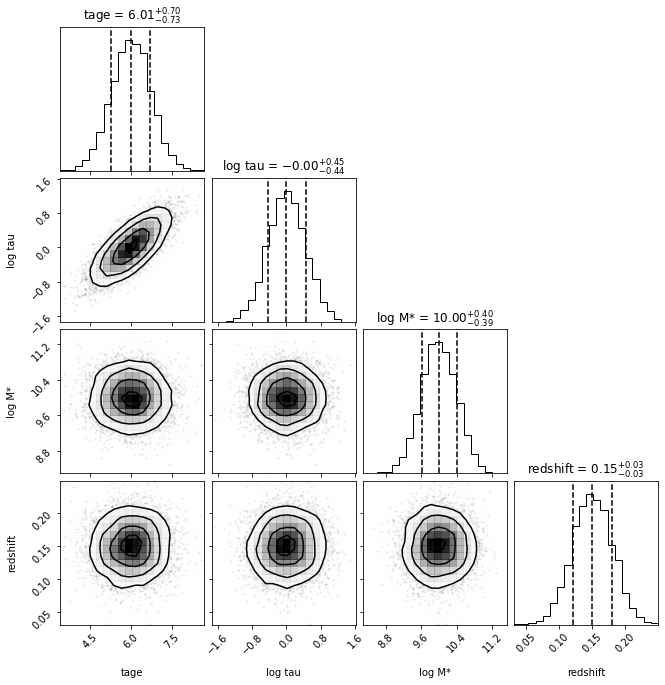

In [187]:
X_data = speculator.predict_mag(y_data, 
                                log_stellar_mass=y_stellar_mass, 
                                redshift=y_redshift,
                                filterset=['sdss_{0}0'.format(b) for b in 'ugriz'],
                                noise=noise, noise_model_dir=noise_model_dir,
                               ).cpu().detach().numpy()
X_data = Tensor(X_data).to('cuda')

_X_data_clean = speculator.predict_mag(y_data, 
                                log_stellar_mass=y_stellar_mass, 
                                redshift=y_redshift,
                                filterset=['sdss_{0}0'.format(b) for b in 'ugriz'],
                                noise=None,
                               ).cpu().detach().numpy()
_X_data_clean = Tensor(_X_data_clean).to('cuda')

figure = corner.corner(np.hstack([y_data.cpu().detach().numpy(), 
                                  y_stellar_mass.cpu().detach().numpy(),
                                  y_redshift.cpu().detach().numpy()]), 
                       quantiles=[0.16, 0.5, 0.84], 
                       labels=['tage', 'log tau', 'log M*', 'redshift'],
                       smooth=0.7,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

In [188]:
torch.std(X_data - _X_data_clean, axis=0)

tensor([0.2526, 0.0289, 0.0274, 0.0334, 0.0875], device='cuda:0')

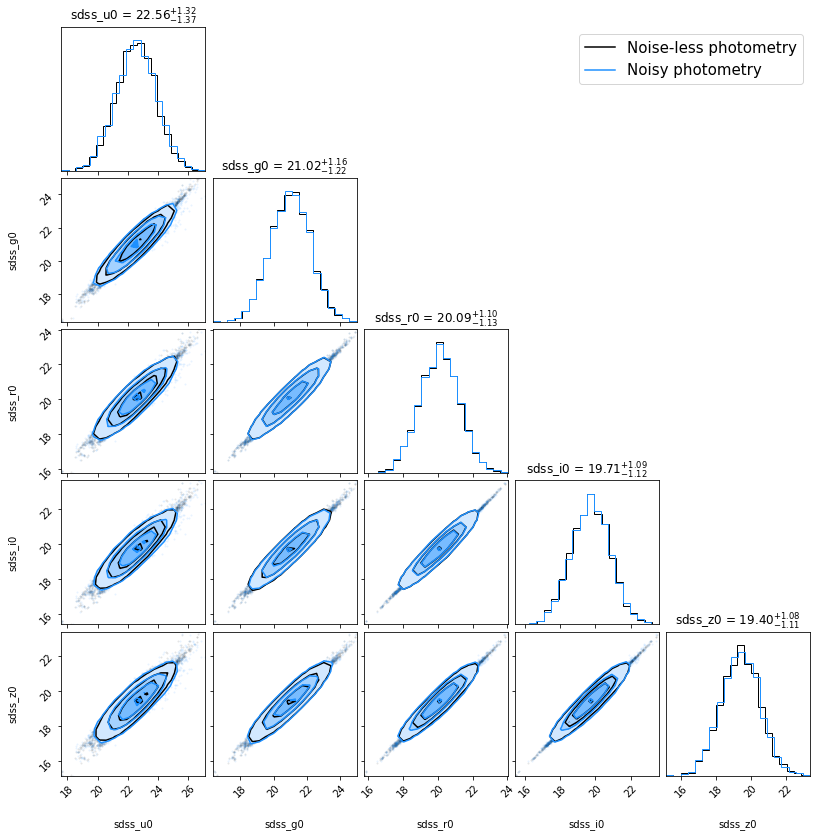

In [189]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Noise-less photometry')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'Noisy photometry')

labels = [f'sdss_{f}0' for f in 'ugriz']

figure = corner.corner(_X_data_clean.cpu().detach().numpy()[:, :], 
                       color='k', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.7, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

nf_plot = corner.corner(X_data.cpu().detach().numpy()[:, :], 
                        color='dodgerblue', fig=figure, labels=labels,
                        #quantiles=[0.16, 0.5, 0.84], 
                        smooth=0.7, fill_contours=True,
                        show_titles=True, 
                        title_kwargs={"fontsize": 12},
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [190]:
from sklearn.model_selection import train_test_split

In [191]:
Y_truth = torch.hstack([y_data, y_stellar_mass, y_redshift])

In [192]:
X_train, X_vali, Y_train, Y_vali = train_test_split(X_data, Y_truth, test_size=0.4, random_state=42)

### We try to achieve our goal with loss = Sinkhorn(X, Y), where X is the observed SED, and Y is the model output.

In [218]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss

NDE_theta = WassersteinNeuralDensityEstimator(method='nsf', num_transforms=5, # 10, 
                                              num_bins=20, 
                                              hidden_features=50, # 120, 
                                              output_dir=None, 
                                              initial_pos={'mean': [5, 1, 10.5, 0.2], 'std': [1, 1, 1, 0.05]},
                                              normalize=False)
NDE_theta.build(
    Y_train,
    X_train,
    optimizer='adam')

NDE_theta.load_validation_data(X_vali, Y_vali)

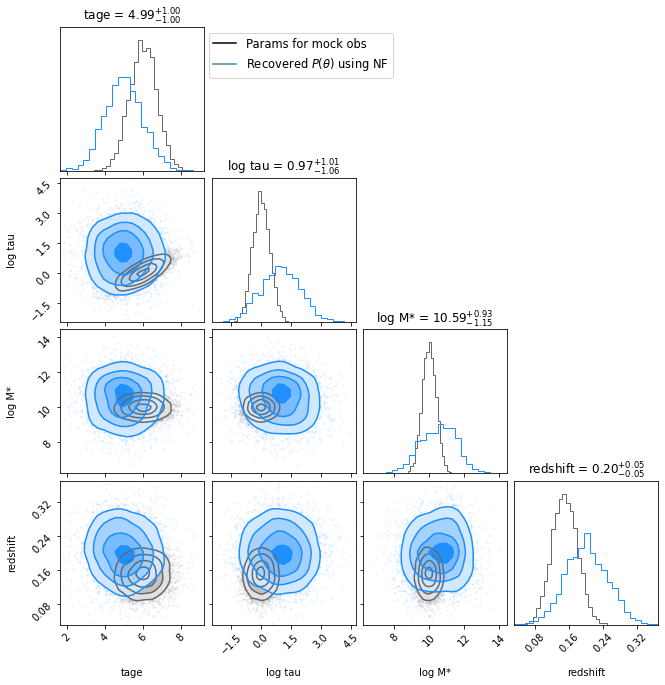

In [219]:
samples = NDE_theta.sample(5000)
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Recovered $P(\theta)$ using NF')

labels = ['tage', 'log tau', 'log M*', 'redshift']

figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=25,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=1, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

nf_plot = corner.corner(samples.cpu().detach().numpy(), 
                  fig=figure, labels=labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [220]:
max_epochs = 6
scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=3e-2, 
                                                steps_per_epoch=100, 
                                                epochs=max_epochs)

In [221]:
for epoch in range(max_epochs):
    print('lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    NDE_theta.train(n_epochs=100, n_samples=3000,
                    speculator=speculator, 
                    noise=noise, noise_model_dir=noise_model_dir,
                    sinkhorn_kwargs={'p': 1, 'blur': 0.01, 'scaling': 0.5},
                   )
    scheduler.step()

lr: 0.0011999999999999997


Loss = -0.920 (train), -0.825 (vali): 100%|████████████████████████| 100/100 [00:28<00:00,  3.52epochs/s]


lr: 0.0012022177624800498


Loss = -0.965 (train), -0.916 (vali): 100%|████████████████████████| 100/100 [00:28<00:00,  3.55epochs/s]


lr: 0.0012088703667993


Loss = -0.973 (train), -0.907 (vali):   4%|█                         | 4/100 [00:01<00:31,  3.05epochs/s]


KeyboardInterrupt: 

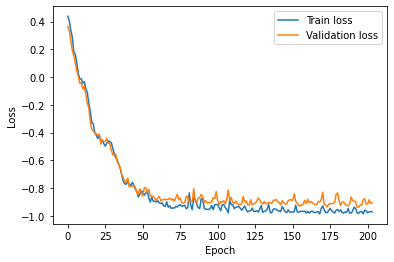

In [222]:
NDE_theta.plot_loss()

In [223]:
NDE_theta.train_loss_history[np.argmin(NDE_theta.vali_loss_history)]

-0.9795413017272949

In [224]:
print('Best epoch:', NDE_theta.best_loss_epoch)
print('Best train loss:', NDE_theta.train_loss_history[NDE_theta.best_loss_epoch - 1])
print('Best vali loss:', NDE_theta.vali_loss_history[NDE_theta.best_loss_epoch - 1])

Best epoch: 0
Best train loss: -0.9734286069869995
Best vali loss: -0.9072377681732178


In [225]:
# with open(f'./nde_theta_best_loss_nsf_{NDE_theta.index}.pkl', 'rb') as f:
#     NDE_theta = pickle.load(f)

In [226]:
NDE_theta.best_model.goodness_of_fit(Y_truth)

Log10 Wasserstein distance in theta space:  -0.796260596149942


Text(0.5, 0.98, 'With noise')

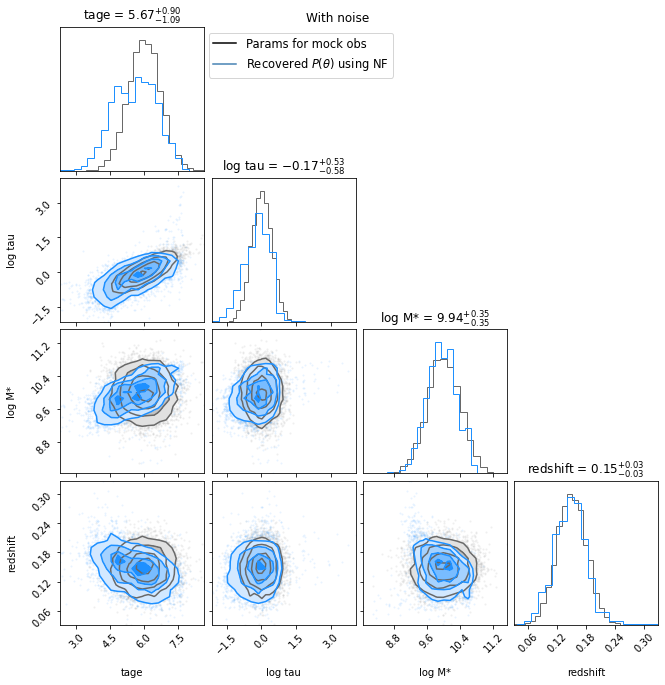

In [228]:
samples = NDE_theta.best_model.sample(5000)
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Recovered $P(\theta)$ using NF')

labels = ['tage', 'log tau', 'log M*', 'redshift']

figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=20,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.5, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

nf_plot = corner.corner(samples.cpu().detach().numpy(), 
                  fig=figure, labels=labels, bins=20,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

plt.suptitle('With noise')

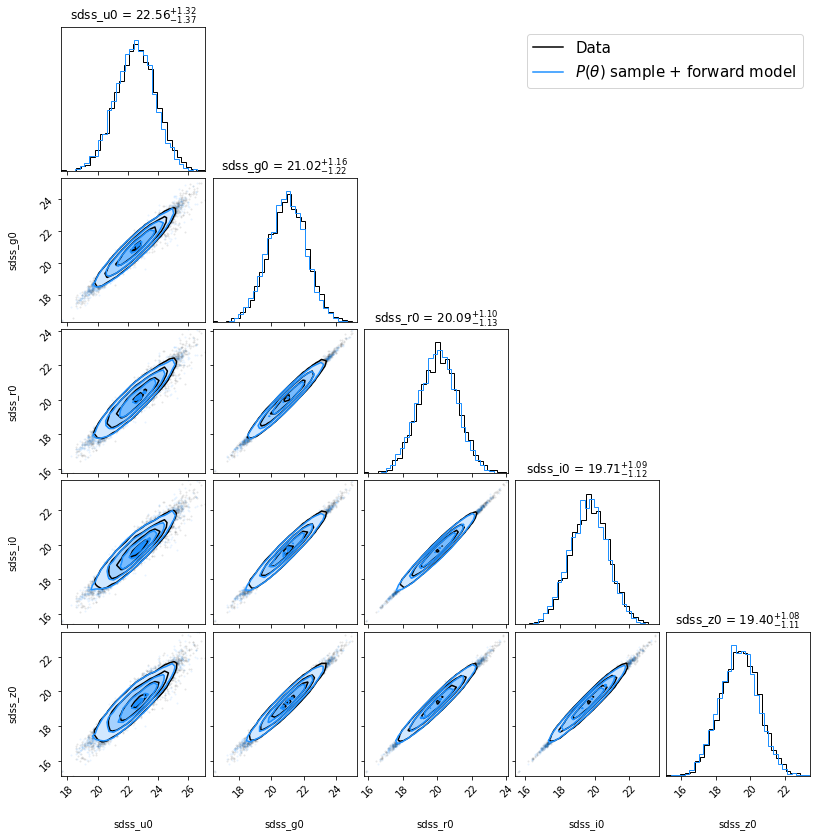

In [203]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = [f'sdss_{f}0' for f in 'ugriz']

figure = corner.corner(X_data.cpu().detach().numpy(), 
                       color='k', labels=labels, bins=30,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.7, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

nf_plot = corner.corner(speculator._predict_mag_with_mass_redshift(samples, 
                                                                   noise=noise, 
                                                                   noise_model_dir=noise_model_dir,
                                                                  ).cpu().detach().numpy(), 
                  fig=figure, labels=labels, bins=30,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.7, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))